In [11]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cbook
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,matplotlib.cbook.mplDeprecation))

# Konstrukce a odhad AR modelu

Máme k dispozici burzovní ceny akcií společnosti Google v období od 7. února 2005 do 7. července 2005. Ty jsou uloženy v souboru `googlestock.txt`, který vypadá následovně:
```
date	   price
2/7/2005    196.03
2/8/2005    198.64
2/9/2005    191.58
2/10/2005   187.98
2/11/2005   187.4
2/14/2005   192.99
```

Načtěte data z druhého sloupce do proměnné `data`, ideálně pro jednoduchost do numpy.array. Do proměnné `ndat` uložte počet měření a vykreslete řadu, ACF a PACF pomocí funkce `tsplot()`. Interpretujte, co grafy znázorňují.

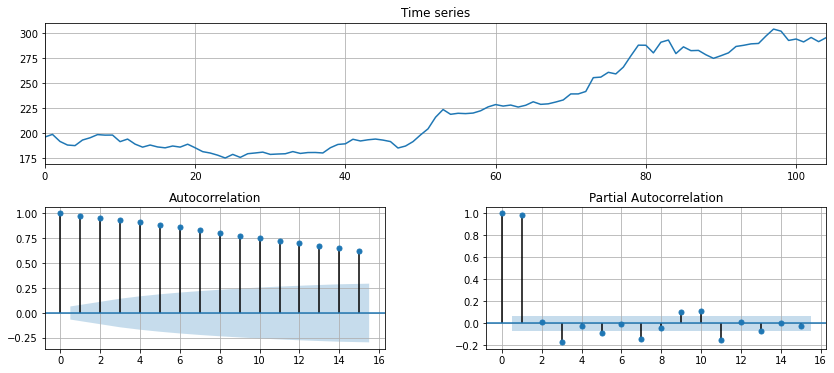

In [12]:
data = np.genfromtxt('googlestock.txt', skip_header=1, usecols=1, autostrip=True)
ndat = data.size
tsplot(data)

Vykreslete 4 grafy - scatterploty - znázorňující závislost pozorované veličiny (ceny) v čase $t$ na ceně v předchozích 4 časech $t-1$, $t-2$, $t-3$ a $t-4$. Pozor na stejná měřítka os. Interpretujte grafy, navíc s pomocí ACF a PACF. 

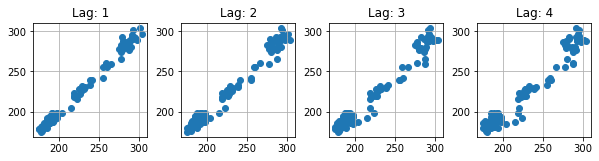

In [13]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(data[i+1:], data[:-(i+1)])
    plt.title('Lag: {0}'.format(i+1))
    plt.axis('image')

NaFITujte mautoregresní model `AR` z balíčku `statsmodels.tsa.ar_model` na data. Je potřeba vhodně zvolit argument `maxlag`, jinak dostanete model výrazně komplikovanější. K tomu se lze propracovat kromě ACF/PACF rovněž pomocí metody `AR.select_order()`, jejíž nápovědu nalezneme rovněž níže. K dispozici máme několik kritérií IC - _information criterion_, vždy hledáme model s menší hodnotou kritéria. Oblíbená jsou:

- [AIC - Akaikeho informační kritérium](https://en.wikipedia.org/wiki/Akaike_information_criterion) - měří kvalitu FITu pomocí vztahu $AIC = 2p - 2\ln(L)$, kde $p$ je počet parametrů a $L$ je likelihood, věrohodnost fitovaných dat. Je asymptoticky ekvivalentní k leave-one-out křížové validaci lineárních regresních modelů.
- [BIC - Bayesovské informační kritérium](https://en.wikipedia.org/wiki/Bayesian_information_criterion) - funguje podobně, akorát podle vztahu $BIC = \ln(n)k - 2\ln(L)$, kde $n$ počet dat.

In [20]:
#help(AR)

In [65]:
model = AR(data)
order = model.select_order(maxlag=10, ic='bic', trend='c', method='cmle')
print('Řád AR modelu: ', order)

Řád AR modelu:  1


Nyní budeme FITovat :-)
Do proměnné `beta` uložte odhady (parametry) z FITu a koukněte na konfidenční intervaly na standardní hladině spolehlivosti 95%.

In [46]:
result = model.fit(maxlag=1)
beta = result.params
print('Odhad vektoru regresních koeficientů: ', beta)
print('Konfidenční intervaly pro parametry (v řádcích):\n', result.conf_int())

Odhad vektoru regresních koeficientů:  [-0.35845344  1.00587089]
Konfidenční intervaly pro parametry (v řádcích):
 [[-4.97002425  4.25311737]
 [ 0.98564579  1.02609599]]


Zajímá nás obvykle i odhad variance šumu. Uložte jej do proměnné `sigma2` a vytiskněte.

In [30]:
sigma2 = result.sigma2
print(f'Odhad variance šumu: {sigma2:.3f}')

Odhad variance šumu: 19.531


Mělo by nás zajímat, zda je proces stacionární. To zjistíme z kořenů charakteristického polynomu položeného rovno nule:

$$
1 - \beta_1 z - \beta_2 z^2 - \ldots - \beta_p z^p  = 0,
$$

což v našem případě vede na jednoduchou rovnici

$$
1 - \beta_1 z = 0,
$$

s řešením

$$
z = \frac{1}{\beta_1}.
$$

Statsmodels toto spočte za nás:

In [56]:
print('Kořen charakteristického polynomu: ', result.roots)

Kořen charakteristického polynomu:  [0.99416338]


Že proces není stacionární jsme v tomto jednoduchém případě poznali už z $|\beta_1|>1$. U složitějších modelů už by to takto přímočaře nešlo.

Zkusíme i pár predikcí budoucích hodnot, jejichž počet si předdefinujeme v proměnné `npreds`. K predikování můžeme použít jak metodu `result.predict()`, tak predikci pomocí skalárního součinu $[1, X_{t-1}]^\intercal \beta$.

Napočítejte 100 kroků predikce:

In [23]:
npreds = 100
for t in range(npreds):
    x_pred = np.dot(beta, [1, data[-1]])
    data = np.append(data, x_pred)        # Append je silně neoptimální ;-)

Vykreslíme data následovaná predikcemi.

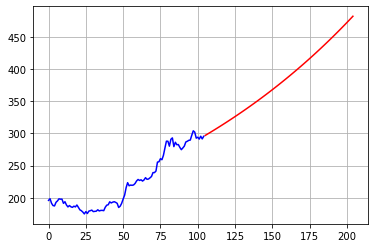

In [24]:
plt.plot(np.arange(ndat), data[:ndat], 'b')
plt.plot(np.arange(ndat, ndat+npreds), data[ndat:], 'r')

V `result.resid` najdeme rezidua regrese na datech, pomocí kterých jsme počítali odhady. Velmi užitečné je kouknout na jejich rozdělení, resp. histogram. Čekali bychom rezidua centrovaná v počátku, ideálně i symetrická.

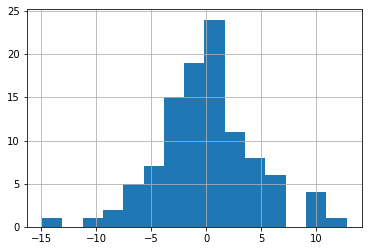

In [59]:
plt.hist(result.resid, bins=15)
plt.show()

**Mnohé z výše uvedených analýz lze zobrazit metodou `summary` :)**

In [58]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:                          AR(1)   Log Likelihood                -302.115
Method:                          cmle   S.D. of innovations              4.419
Date:                Tue, 29 Sep 2020   AIC                              3.030
Time:                        23:28:38   BIC                              3.106
Sample:                             0   HQIC                             3.061
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3585      2.353     -0.152      0.879      -4.970       4.253
L1.y           1.0059      0.010     97.476      0.000       0.986       1.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9942           +0.0000j            0.9942            0.0000
-----------------------------------------------------------------------------
"""